In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'] 는 전체 train 데이터셋으로 설정되어 있는 데이터셋을 80%, 10%, 10% 세 부분으로 나누어 각각 train_data, validation_data, test_data로 사용하겠다는 의미이다.

In [3]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Dataset의 shape는 (image, label)의 형태로 나타낸다. 첫 번재 인자인 image는 (height, width, channel)로 나타내는데 위의 데이터에서는 (None, None, 3)으로 나타났다. height와 width가 None으로 나타난 이유는 이미지의 크기가 모두 달라 사이즈가 정해져 있지 않기 때문이다. channel은 이미지의 색을 표현하는 채널의 수를 나타낸다. 흑백 이미지의 경우에는 2로 나타내고 컬러 이미지의 경우 RGB로 나타내기 때문에 3으로 나타낸다. 저번 프로젝트에서 png파일의 channel을 4로 설정해두었던 것 같은데 아마 png는 CMYK로 나타내서 그런 듯 하다.(아닐 수도 있으니 확인해보기)두 번째 인자인 label은 특정 이미지가 무엇을 나타내는지 알려주는 단일 값이다. 1차원의 숫자 하나로 표현되기 때문에 차원이 따로 나타나지는 않는다.

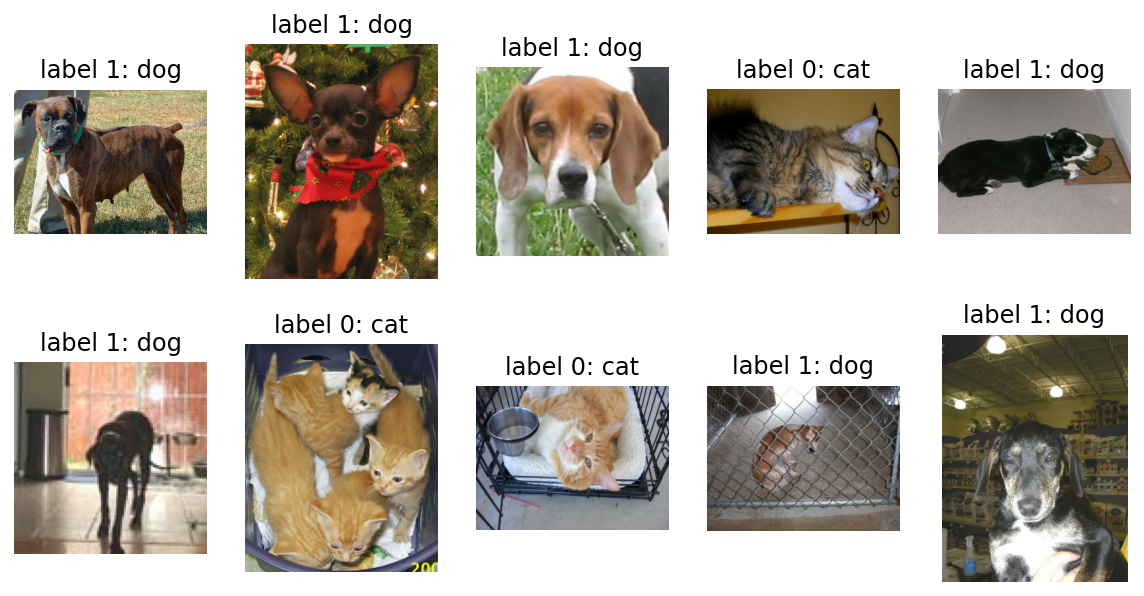

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터 가져오기
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

라벨을 확인해보니 고양이는 0, 강아지는 1로 설정되어 있다. 이미지를 보니 사이즈가 모두 달라 이미지를 통일시켜 주는 작업이 필요해보인다. 이미지의 사이즈는 160*160 픽셀로 통일시키려 한다.

In [5]:
IMG_SIZE = 160 # resize시킬 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32) 
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

 image = tf.cast(image, tf.float32)는 image=float(image)과 같은 타입캐스팅의 텐서플로우 버전이다. 타입 캐스팅은 다른 데이터 타입으로 형(타입)을 바꿔주는 것을 의미한다. 정수형을 실수형으로 바꾸기 위해 float()를 사용하는 것이 타입캐스팅의 한 예다. 이미지의 원래 픽셀 값은 RGB를 나타낼 때 주로 사용되는 0 ~ 255 사이의 정수값이었다. 이 값들의 중간값인 127.5로 나누고 1을 빼주어 -1 ~ 1 사이의 실수값이 되도록 한 것이 image = (image/127.5) - 1 이다.

In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


map()함수를 이용해 format_example()함수를 raw_train, raw_validation, raw_test에 적용시켰다. 이를 통해 동일한 모양의 train, validataion, test 데이터셋을 얻을 수 있었다. 정말 이미지 크기가 같아졌는지 이전에 출력했던 10장의 이미지를 다시 확인해보자.

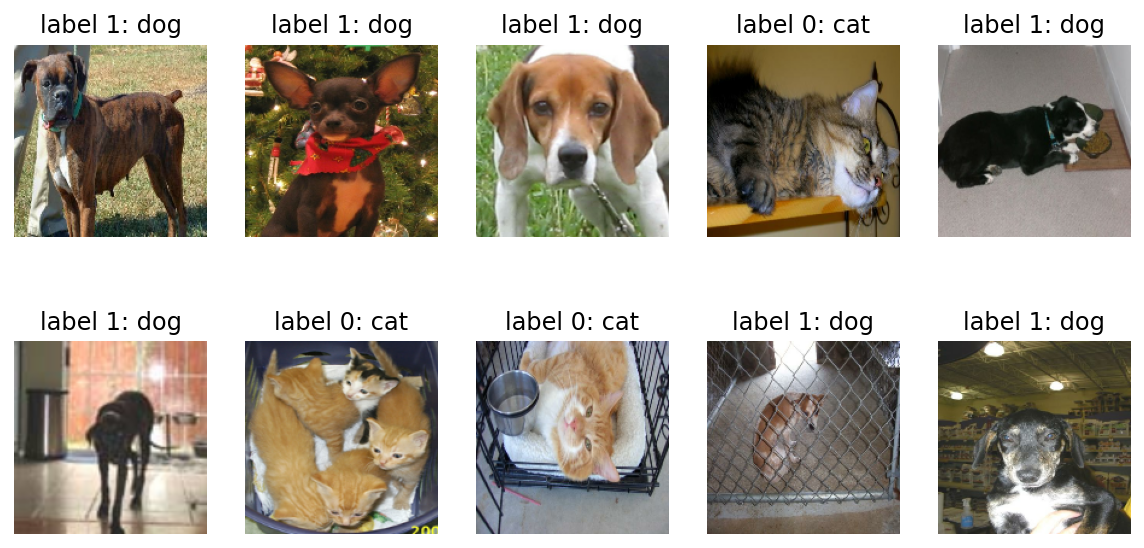

In [7]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

----------------------여기까지 데이터 준비-----------------------
이제는 모델링!

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

models는 모델 그 자체를 구축하기 위한 함수들을 포함하고 있다. 그리고 layers에는 모델의 구성 요소인 여러 가지 종류의 레이어라는 함수들을 가지고 있다. Sequential은 말 그대로 연속적인 모델을 쌓기 위한 함수이다. Sequential 함수 안에 연속적으로 여러 가지 레이어들이 들어간다.

In [10]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)            

Conv2D, MaxPooling2D, Flatten, Dense라는 네 가지 종류의 레이어를 사용했다. summary() 메소드를 통해 모델의 전체 구조를 살펴보면 레이어가 층층이 쌓여있는 것을 볼 수 있다. 딥러닝은 언제나 이렇게 층층히 쌓여 있는 구조를 보인다. 처음 이미지는 (160, 160, 3)의 크기였는데 레이어를 지날수록 형태가 달라지고 있다. 이미지는 첫 번째 레이어인 conv2d부터 여섯 번째 레이어인 max_pooling2d_2까지 지나면서 height와 width는 160 → 80 → 40 → 20 으로 점점 작아지고, channel은 16 → 32 → 64까지 커지고 있다. 처음 6개의 레이어를 지나고 난 후의 shape는 (None, height, width, channel)로 4차원이다.<br>
None은 배치(batch) 사이즈에 따라 모델에 다른 수의 입력이 들어올 수 있음을 나타낸다. 데이터 하나의 크기는 (height, width, channel)로 3차원인데, 6개의 레이어를 지나면서 height와 width는 점점 작아지고, channel은 점점 커지다가, flatten 계층을 만나 25,600(20x20x64)이라는 하나의 숫자인 1차원으로 shape가 줄어든다. 점점 작은 feature map이 출력되다가, Flatten과 Dense 레이어를 거쳐 1차원으로 shape이 줄어드는 네트워크는 CNN을 사용한 딥러닝 모델의 가장 대표적인 형태이다.

In [11]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


optimizer는 학습을 어떤 방식으로 시킬 것인지 결정한다. 어떻게 최적화시킬 것인지를 결정하기 때문에 최적화 함수라고 부르기도 한다.<br><br>
loss는 모델이 학습해나가야 하는 방향을 결정한다. 이 문제에서는 모델의 출력은 입력받은 이미지가 고양이인지 강아지인지에 대한 확률분포로 두었으므로, 입력 이미지가 고양이(label=0)일 경우 모델의 출력이 [1.0, 0.0]에 가깝도록, 강아지(label=1)일 경우 [0.0, 1.0]에 가까워지도록 하는 방향을 제시한다.<br><br>
metrics는 모델의 성능을 평가하는 척도이다. 분류 문제를 풀 때, 성능을 평가할 수 있는 지표는 정확도(accuracy), 정밀도(precision), 재현율(recall) 등이 있다. 여기서는 정확도를 사용했다.

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

BATCH_SIZE로 한 스텝에 학습시킬 데이터의 개수를 의미하고 SHUFFLE_BUFFER_SIZE를 설정해둠으로써 학습 데이터를 섞어줄 수 있다. BATCH_SIZE에 따라 32개의 데이터를 랜덤으로 뿌려줄 train_batches, validation_batches, test_batches를 만들어 주었다. train_batches는 모델이 끊임없이 학습될 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해준다. 

In [16]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

테스트로 하나의 batch를 뽑아보았다. image_batch의 shape는 (160, 160, 3)의 shape인 32개의 데이터가 존재한다는 뜻이다. 또한 label은 강아지이면 1, 고양이이면 0으로 정답 label을 나타내기 때문에 한 batch에 데이터가 32개라면 label은 0 또는 1의 32개의 숫자로만 구성된다.

다음은 본격적인 모델을 만들기에 앞서 만든 초기 모델이다. 검증(validation)을 위한 데이터셋인 validation_batches를 이용해 20번의 예측을 해 보고, 평균 loss와 평균 accuracy를 확인한다.

In [17]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/20 [===============>..............] - ETA: 0s - loss: 0.6954 - accuracy: 0.5142

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 3s 29ms/step - loss: 0.6962 - accuracy: 0.5188
initial loss: 0.70
initial accuracy: 0.52


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


initial loss는 0.70이 나왔고 initial accuracy는 0.52이 나왔다. loss는 모델이 얼마나 틀렸는지를 나타내기 때문에 당연히 낮게 나올수록 좋다. accuracy는 정확도를 나타내는데 우리가 만든 모델은 강아지와 고양이 둘 중 하나를 분류하는 모델인데 찍어도 50%의 정확도가 나오므로 52%라는 정확도는 이 모델이 의미없는 예측을 했다고 판단할 수 있다. 이유는 아직 모델을 학습시키지 않았기 때문이다. 그러면 이번에는 10epoch를 학습시켜 정확도가 변하는 것을 확인해볼 예정이다.

In [18]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
168/582 [=======>......................] - ETA: 33s - loss: 0.6550 - accuracy: 0.6077

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.6434 - accuracy: 0.6187

210/582 [=========>....................] - ETA: 30s - loss: 0.6413 - accuracy: 0.6216

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.6250 - accuracy: 0.6416

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.5890 - accuracy: 0.6756

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.5880 - accuracy: 0.6776

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.5872 - accuracy: 0.6782

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.5821 - accuracy: 0.6822

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.5814 - accuracy: 0.6828

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5773 - accuracy: 0.6858

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 54s 87ms/step - loss: 0.5773 - accuracy: 0.6858 - val_loss: 0.5292 - val_accuracy: 0.7390
Epoch 2/10
167/582 [=======>......................] - ETA: 33s - loss: 0.5050 - accuracy: 0.7483

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 31s - loss: 0.4974 - accuracy: 0.7533

209/582 [=========>....................] - ETA: 30s - loss: 0.4993 - accuracy: 0.7530

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 24s - loss: 0.4925 - accuracy: 0.7608

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.4729 - accuracy: 0.7726

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.4720 - accuracy: 0.7732

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.4718 - accuracy: 0.7735

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.4682 - accuracy: 0.7755

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.4678 - accuracy: 0.7757

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.7760

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 87ms/step - loss: 0.4677 - accuracy: 0.7760 - val_loss: 0.5080 - val_accuracy: 0.7468
Epoch 3/10
168/582 [=======>......................] - ETA: 33s - loss: 0.4405 - accuracy: 0.8017

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 30s - loss: 0.4371 - accuracy: 0.8050

211/582 [=========>....................] - ETA: 30s - loss: 0.4366 - accuracy: 0.8048

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 24s - loss: 0.4279 - accuracy: 0.8091

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.4071 - accuracy: 0.8180

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.4062 - accuracy: 0.8187

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.4059 - accuracy: 0.8191

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.4056 - accuracy: 0.8192

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.4054 - accuracy: 0.8194

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.8195

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 51s 85ms/step - loss: 0.4039 - accuracy: 0.8196 - val_loss: 0.4722 - val_accuracy: 0.7842
Epoch 4/10
167/582 [=======>......................] - ETA: 33s - loss: 0.3809 - accuracy: 0.8286

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 30s - loss: 0.3775 - accuracy: 0.8309

209/582 [=========>....................] - ETA: 30s - loss: 0.3745 - accuracy: 0.8331

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 24s - loss: 0.3678 - accuracy: 0.8366

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/582 [========================>.....] - ETA: 7s - loss: 0.3538 - accuracy: 0.8457

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


502/582 [========================>.....] - ETA: 6s - loss: 0.3524 - accuracy: 0.8465

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.3521 - accuracy: 0.8467

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.3499 - accuracy: 0.8474

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.3497 - accuracy: 0.8475

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.3490 - accuracy: 0.8475

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 52s 85ms/step - loss: 0.3492 - accuracy: 0.8473 - val_loss: 0.4778 - val_accuracy: 0.7773
Epoch 5/10
168/582 [=======>......................] - ETA: 34s - loss: 0.3219 - accuracy: 0.8653

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.3211 - accuracy: 0.8656

210/582 [=========>....................] - ETA: 31s - loss: 0.3209 - accuracy: 0.8646

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.3135 - accuracy: 0.8695

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.2982 - accuracy: 0.8741 ETA: 7s - loss: 0.2983 - accuracy: 0.87

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.2977 - accuracy: 0.8743

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.2966 - accuracy: 0.8747

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 3s - loss: 0.2954 - accuracy: 0.8756

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.2951 - accuracy: 0.8758

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.8764

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 87ms/step - loss: 0.2941 - accuracy: 0.8764 - val_loss: 0.4883 - val_accuracy: 0.7859
Epoch 6/10
168/582 [=======>......................] - ETA: 34s - loss: 0.2699 - accuracy: 0.8903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.2642 - accuracy: 0.8927

211/582 [=========>....................] - ETA: 30s - loss: 0.2651 - accuracy: 0.8919

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.2573 - accuracy: 0.8967

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.2469 - accuracy: 0.9008

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.2461 - accuracy: 0.9010

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.2451 - accuracy: 0.9015

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.2444 - accuracy: 0.9015

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.2443 - accuracy: 0.9013

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.9015

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 52s 86ms/step - loss: 0.2432 - accuracy: 0.9016 - val_loss: 0.5006 - val_accuracy: 0.7915
Epoch 7/10
168/582 [=======>......................] - ETA: 33s - loss: 0.2146 - accuracy: 0.9137

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 30s - loss: 0.2156 - accuracy: 0.9152

210/582 [=========>....................] - ETA: 30s - loss: 0.2150 - accuracy: 0.9161

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.2070 - accuracy: 0.9212

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1976 - accuracy: 0.9256

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1967 - accuracy: 0.9261

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1969 - accuracy: 0.9260

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.1952 - accuracy: 0.9264

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.1945 - accuracy: 0.9269

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9269

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 87ms/step - loss: 0.1944 - accuracy: 0.9269 - val_loss: 0.5439 - val_accuracy: 0.7915
Epoch 8/10
168/582 [=======>......................] - ETA: 34s - loss: 0.1600 - accuracy: 0.9412

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1587 - accuracy: 0.9411

211/582 [=========>....................] - ETA: 30s - loss: 0.1604 - accuracy: 0.9399

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 24s - loss: 0.1561 - accuracy: 0.9419

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


491/582 [========================>.....] - ETA: 7s - loss: 0.1483 - accuracy: 0.9449

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


504/582 [========================>.....] - ETA: 6s - loss: 0.1488 - accuracy: 0.9445

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1485 - accuracy: 0.9444

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1467 - accuracy: 0.9452

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1474 - accuracy: 0.9448

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9457

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 52s 85ms/step - loss: 0.1461 - accuracy: 0.9456 - val_loss: 0.6025 - val_accuracy: 0.7752
Epoch 9/10
167/582 [=======>......................] - ETA: 34s - loss: 0.1229 - accuracy: 0.9577

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/582 [=========>....................] - ETA: 31s - loss: 0.1233 - accuracy: 0.9571

210/582 [=========>....................] - ETA: 30s - loss: 0.1229 - accuracy: 0.9579

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


281/582 [=============>................] - ETA: 24s - loss: 0.1171 - accuracy: 0.9605

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1116 - accuracy: 0.9617

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1114 - accuracy: 0.9616

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


513/582 [=========================>....] - ETA: 5s - loss: 0.1111 - accuracy: 0.9618

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 3s - loss: 0.1091 - accuracy: 0.9629

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


546/582 [===========================>..] - ETA: 2s - loss: 0.1094 - accuracy: 0.9628

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.1094 - accuracy: 0.9628

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 52s 85ms/step - loss: 0.1094 - accuracy: 0.9628 - val_loss: 0.6206 - val_accuracy: 0.7863
Epoch 10/10
170/582 [=======>......................] - ETA: 19s - loss: 0.0864 - accuracy: 0.9728

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 [=========>....................] - ETA: 17s - loss: 0.0859 - accuracy: 0.9726

212/582 [=========>....................] - ETA: 16s - loss: 0.0851 - accuracy: 0.9733

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


283/582 [=============>................] - ETA: 13s - loss: 0.0829 - accuracy: 0.9743

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 [========================>.....] - ETA: 3s - loss: 0.0821 - accuracy: 0.9743

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 [=========================>....] - ETA: 3s - loss: 0.0815 - accuracy: 0.9744

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 2s - loss: 0.0812 - accuracy: 0.9746

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


542/582 [==========================>...] - ETA: 1s - loss: 0.0801 - accuracy: 0.9751

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


550/582 [===========================>..] - ETA: 1s - loss: 0.0803 - accuracy: 0.9752

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.0796 - accuracy: 0.9755

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9



582/582 [==============================] - 29s 46ms/step - loss: 0.0795 - accuracy: 0.9756 - val_loss: 0.7078 - val_accuracy: 0.7846


accuracy는 학습하고 있는 데이터에 대한 정확도를 나타내고 val_accuracy는 학습하지 않은 검증 데이터에 대한 정확도이다. 당연히 훈련 데이터에 대한 정확도가 높게 나온다. 위에서 accuracy는 약 97.56%가 나왔고 val_accuracy는 78.46이 나왔다. 학습 단계에 따른 정확도를 살펴보면 다음과 같다.

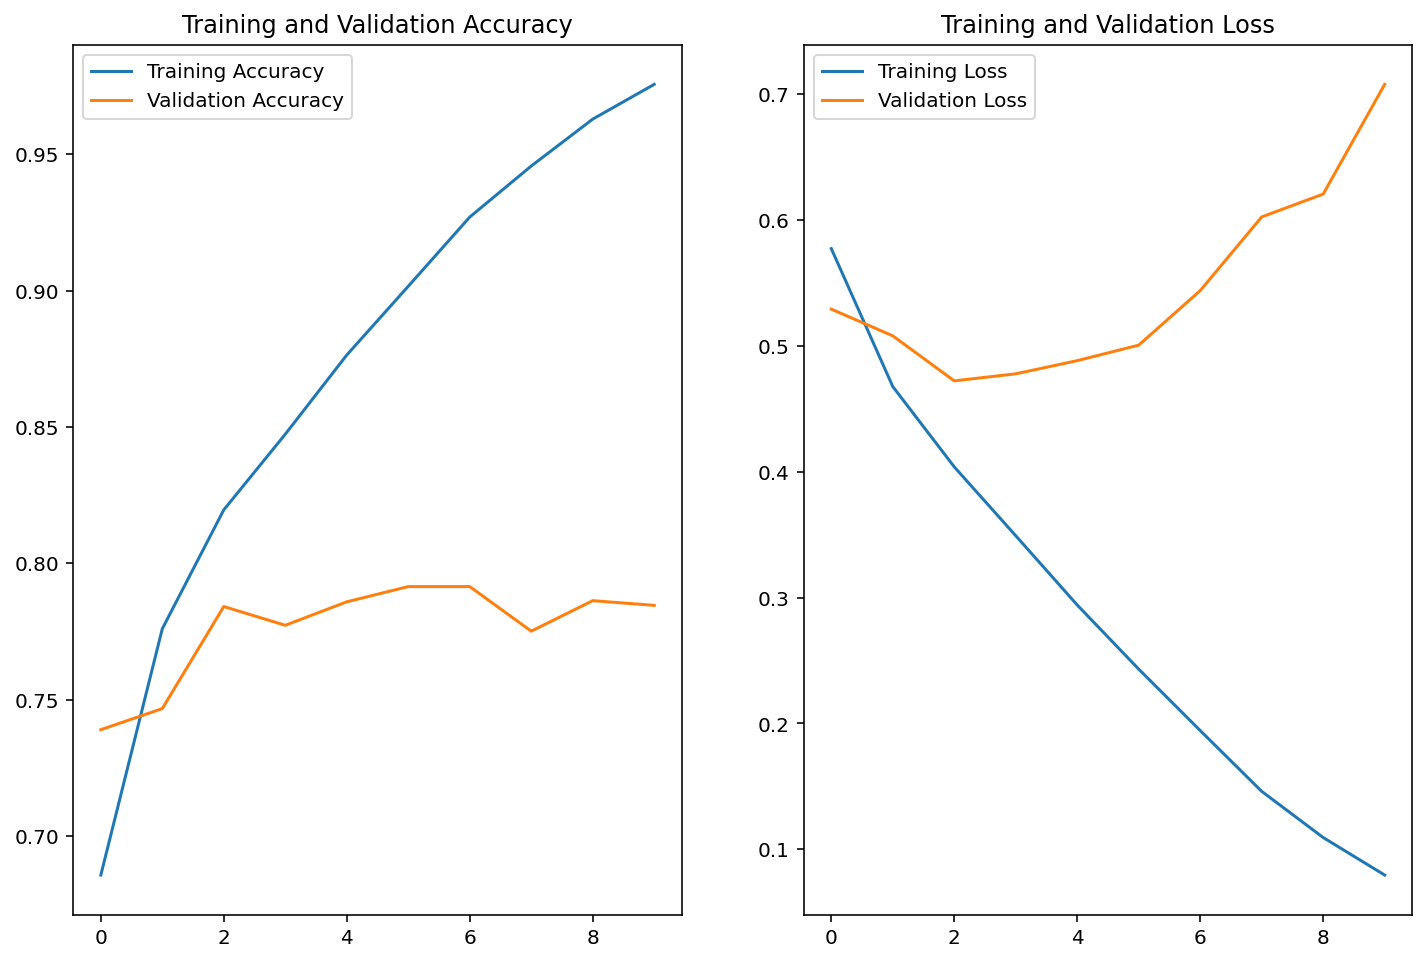

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

training accuracy는 현재 학습하는 데이터셋에 대한 정확도이기 때문에 모델의 구조나 데이터셋 등에 문제가 없다면 일반적으로 학습하면 할수록 꾸준히 계속 오른다. 반면 validation accuracy는 학습하지 않은 데이터셋에 대한 정확도이기 때문에 일정수준까지 오른 후에는 계속 오를지 장담할 수 없다. 심지어 loss 그래프에서 training loss는 계속 안정적으로 줄어들지만, validation loss값은 특정 순간 이후로 다시 커지는 모습을 보인다. 모델의 성능이 제대로 올라가려면 학습하지 않은 데이터에 대해서도 성능이 좋아야 하는데, 훈련 데이터만으로 계속 학습하다 보니 그 데이터에만 과도하게 적합(overfitting) 되어서 일반화 능력이 떨어지게 되는 것이다.<br><br>
마지막으로 이 모델을 이용해 test data를 적용시켜 모델의 예측 결과를 확인해보려 한다.

In [20]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9999809e-01, 1.8761642e-06],
       [9.7893506e-01, 2.1064995e-02],
       [1.7872261e-01, 8.2127744e-01],
       [9.9999881e-01, 1.1983869e-06],
       [2.5209758e-02, 9.7479022e-01],
       [5.5424672e-01, 4.4575328e-01],
       [3.1053014e-03, 9.9689472e-01],
       [9.9874014e-01, 1.2598274e-03],
       [3.0346799e-01, 6.9653201e-01],
       [5.7570163e-02, 9.4242990e-01],
       [1.3176392e-01, 8.6823606e-01],
       [9.9717700e-01, 2.8229994e-03],
       [9.9654359e-01, 3.4564196e-03],
       [2.5003127e-04, 9.9974996e-01],
       [8.6441159e-01, 1.3558842e-01],
       [9.9798512e-01, 2.0149059e-03],
       [5.8573682e-02, 9.4142628e-01],
       [3.7195219e-05, 9.9996281e-01],
       [9.9725193e-01, 2.7481266e-03],
       [9.9999774e-01, 2.2449515e-06],
       [4.0457219e-01, 5.9542775e-01],
       [8.0410600e-01, 1.9589400e-01],
       [9.9707967e-01, 2.9202951e-03],
       [9.4070113e-01, 5.9298843e-02],
       [9.9926001e-01, 7.3999917e-04],
       [2.2594044e-03, 9.

model.predict를 활용해 모델의 예측 결과를 확인해보면 소수점들로 이루어져 있는 것을 확인해볼 수 있는데, [1.0, 0.0]에 가까울수록 label이 0인 고양이로, [0.0, 1.0]에 가까울수록 label이 1인 강아지로 예측했다고 볼 수 있다. 보기 쉽게 라벨과 이미지로 변환해보면 다음과 같다.

In [22]:
import numpy as np

predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

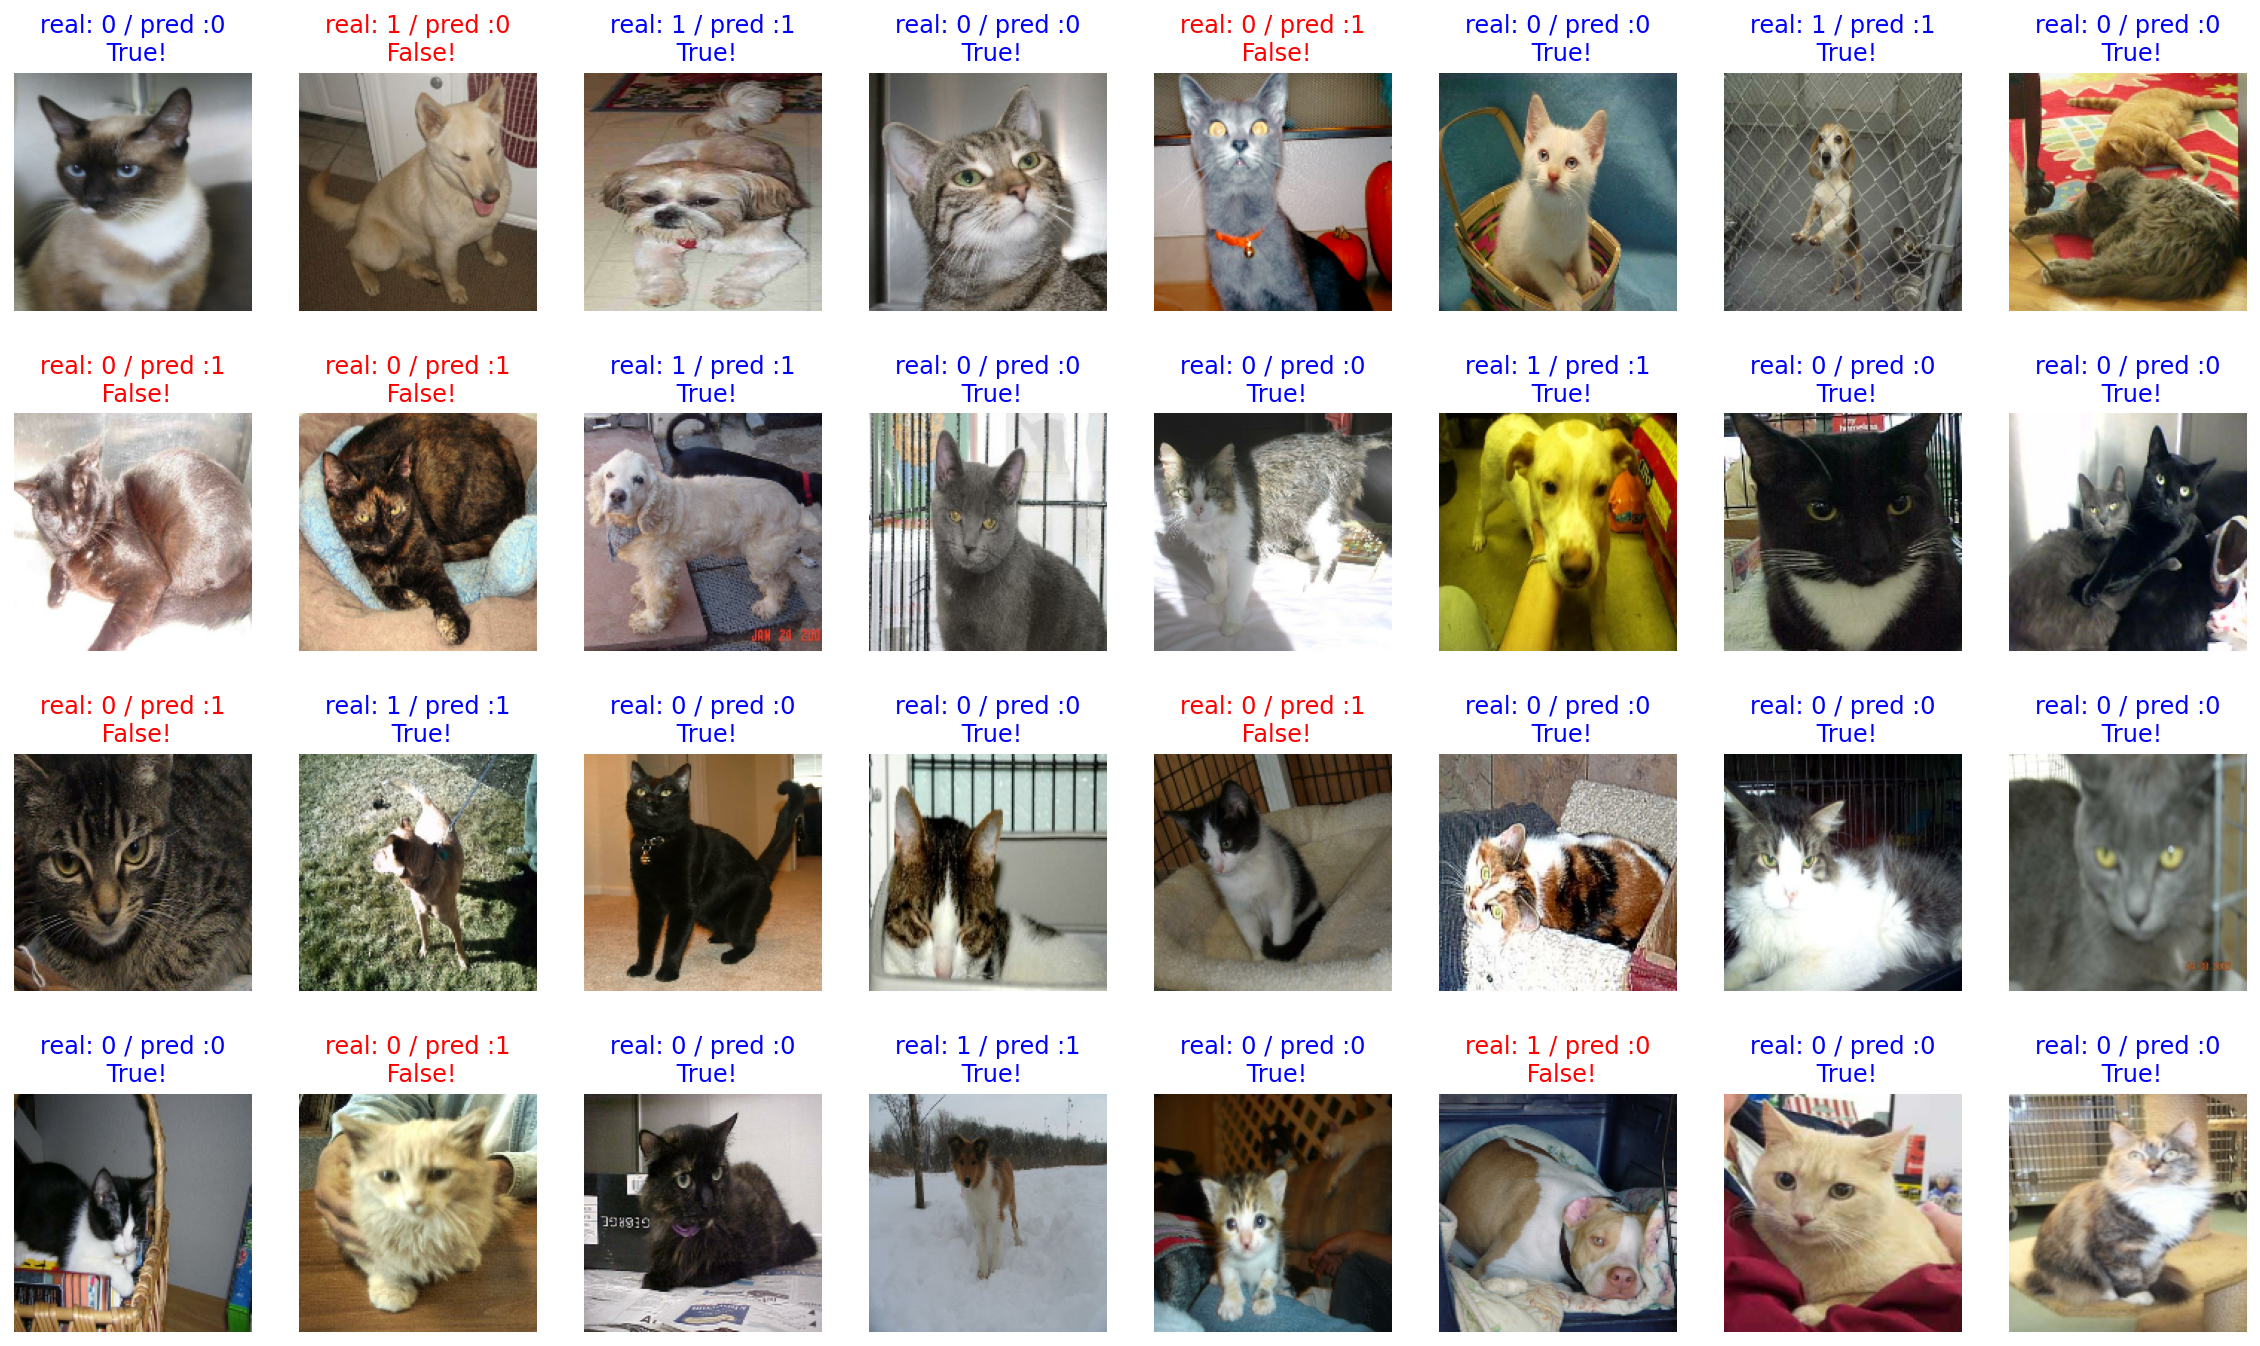

In [23]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [24]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)   

75.0


32개의 이미지에 대한 예측의 정확도는 75%로 나왔다. 조금은 아쉬운 정확도였다. 다음에는 정확도를 높일수 있는 모델을 가져와 활용해보려 한다.